In [42]:
#Librairies for maths
import numpy as np
import matplotlib.pyplot as plt

#Libararies for deep learning
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms

In [43]:
#Conversion of each class in string
Cifar10Labels = [
"airplane",
"automobile",
"bird",
"cat",
"deer",
"dog",
"frog",
"horse",
"ship",
"truck"]

In [44]:
#Identification if the computer has a GPU. If yes, it will be used for computation
def HardwareIdentification():
    if torch.cuda.is_available():
        Device = "cuda" 
    else:
        Device = "cpu"
    print(Device)
    return Device
Device = HardwareIdentification()

cuda


In [45]:
#Batch parameters
BatchSizeTrain = 64
BatchSizeTest = 64

#Picture normalization
AllTransforms = transforms.Compose([transforms.Resize((32,32)),transforms.ToTensor()])

#datasets download
TrainDataSet = datasets.CIFAR10(root = './data', train = True, transform = AllTransforms, download = True)
TestDataset = datasets.CIFAR10(root = './data', train = False, transform = AllTransforms, download=True)

#The datasets are converted into a loader
TrainLoader = torch.utils.data.DataLoader(dataset = TrainDataSet, batch_size = BatchSizeTrain, shuffle = True)
TestLoader = torch.utils.data.DataLoader(dataset = TestDataset,batch_size = BatchSizeTest, shuffle = True)   

Files already downloaded and verified
Files already downloaded and verified


In [46]:
#Model definition
class ConvNeuralNet(nn.Module):

    #Layers initilisation
    def __init__(self, num_classes):

        #Base class called
        super(ConvNeuralNet, self).__init__()

        #3 Convolution layers
        self.Conv1 = nn.Sequential( 
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride = 1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.Conv2 = nn.Sequential( 
        nn.Conv2d(in_channels=64, out_channels=128, stride = 1, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=128, out_channels=128, stride = 1, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
      
        self.Conv3 = nn.Sequential( 
        nn.Conv2d(in_channels=128, out_channels=256, stride = 1, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=256, out_channels=256, stride = 1, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        #3 Linear layers
        self.F1 = nn.Linear(256*4*4, 1024)
        self.Act1 = nn.ReLU()
        self.F2 = nn.Linear(1024, 512)
        self.Act2 = nn.ReLU()
        self.F3 = nn.Linear(512, num_classes)
     
    #Function called to compute a prediction
    def forward(self, x):

      #Convolutional layers 
      Out = self.Conv1(x)
      Out = self.Conv2(Out)
      Out = self.Conv3(Out)

      #Pictures are converted into vectors 
      Out = Out.reshape(Out.size(0), -1)     

      #Linear layers 
      Out = self.F1(Out)
      Out = self.Act1(Out)
      Out = self.F2(Out)
      Out = self.Act2(Out)
      Out = self.F3(Out)

      return Out

In [47]:
#Instance of the model
Model = ConvNeuralNet(10)
Model = Model.to(Device)

In [48]:
#Training function
def Trainloop(DataLoader, Model, Loss, Optimizer, device):
    Sum = 0
    #For all the batched from the loader
    for Iter, (X, y) in enumerate(DataLoader):
        #It is required to compute the gradient
        X.requires_grad = True 
        #Model prediction
        y_pred = Model(X.to(device))
        #Loss computation
        Myloss = Loss(y_pred, y.to(device))
        #Backward propagation
        Optimizer.zero_grad()
        Myloss.backward()
        Optimizer.step()

        Sum += Myloss.item()
    Sum /= len(DataLoader)

    #Return the loss
    return Sum

In [49]:
#Parameters for the training
Epochs = 20
Loss = nn.CrossEntropyLoss()
LearningRate = 0.001
#Adam improve the gradient descent convergence
Optimizer = torch.optim.Adam(Model.parameters(), lr=LearningRate)  

In [57]:
#For each epoch, the model is updated and de the loss displayed
for Epoch in range(Epochs):
    ReturnLoss = Trainloop(TrainLoader, Model, Loss, Optimizer, Device)
    print('{:.4f}'.format(ReturnLoss))

#The model is finally trained, it will be possible to apply the FGSM

0.0894
0.0804
0.0772
0.0768
0.0744
0.0745
0.0725
0.0653
0.0771
0.0716
0.0743
0.0666
0.0727
0.0706
0.0547
0.0651
0.0600
0.0681
0.0661
0.0610


In [51]:
#Function to display 5 pictures from CIFAR10 
def Display5ImagesCIFAR10(Batch, LabelBatch, Prob):
    Fig, Axs = plt.subplots(nrows=1, ncols=5, figsize=(32, 32))
    for i in range(5):
      Img = Batch[i]
      label = LabelBatch[i]
      Axs[i].set_title(str(Cifar10Labels[label.numpy()]) + f" {(100*Prob[i]):>0.1f}%")
      Axs[i].imshow(transforms.ToPILImage()(Img))
    
    plt.tight_layout()
    plt.show()
    return

In [52]:
#Test function
def Test(dataloader, Model, Loss, Device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, Correct = 0, 0,
    
    #For all the batches
    for X, y in dataloader:
        X = X.to(Device)
        y = y.to(Device)  
        #No need to compute gradient descent
        X.requires_grad = False 

        #Model prediction
        Pred = Model(X)

        #Results verification
        Correct += (Pred.argmax(1) == y).type(torch.float).sum().item()

    Correct /= size

    #The accuracy is displayed
    print(f"Test Error: \n Accuracy: {(100*Correct):>0.1f}%")

    X = X.to("cpu")
    y = y.to("cpu")  

    #Convert values into probabilities
    m = torch.nn.Softmax(dim=1)

    ProbPred = m(Pred)
    Pred = Pred.argmax(1).to("cpu") 
    ProbPred = torch.max(ProbPred.to("cpu"), 1).values

    #Display 5 pictures from CIFAR10
    Display5ImagesCIFAR10(X,Pred,ProbPred)

Test Error: 
 Accuracy: 75.5%


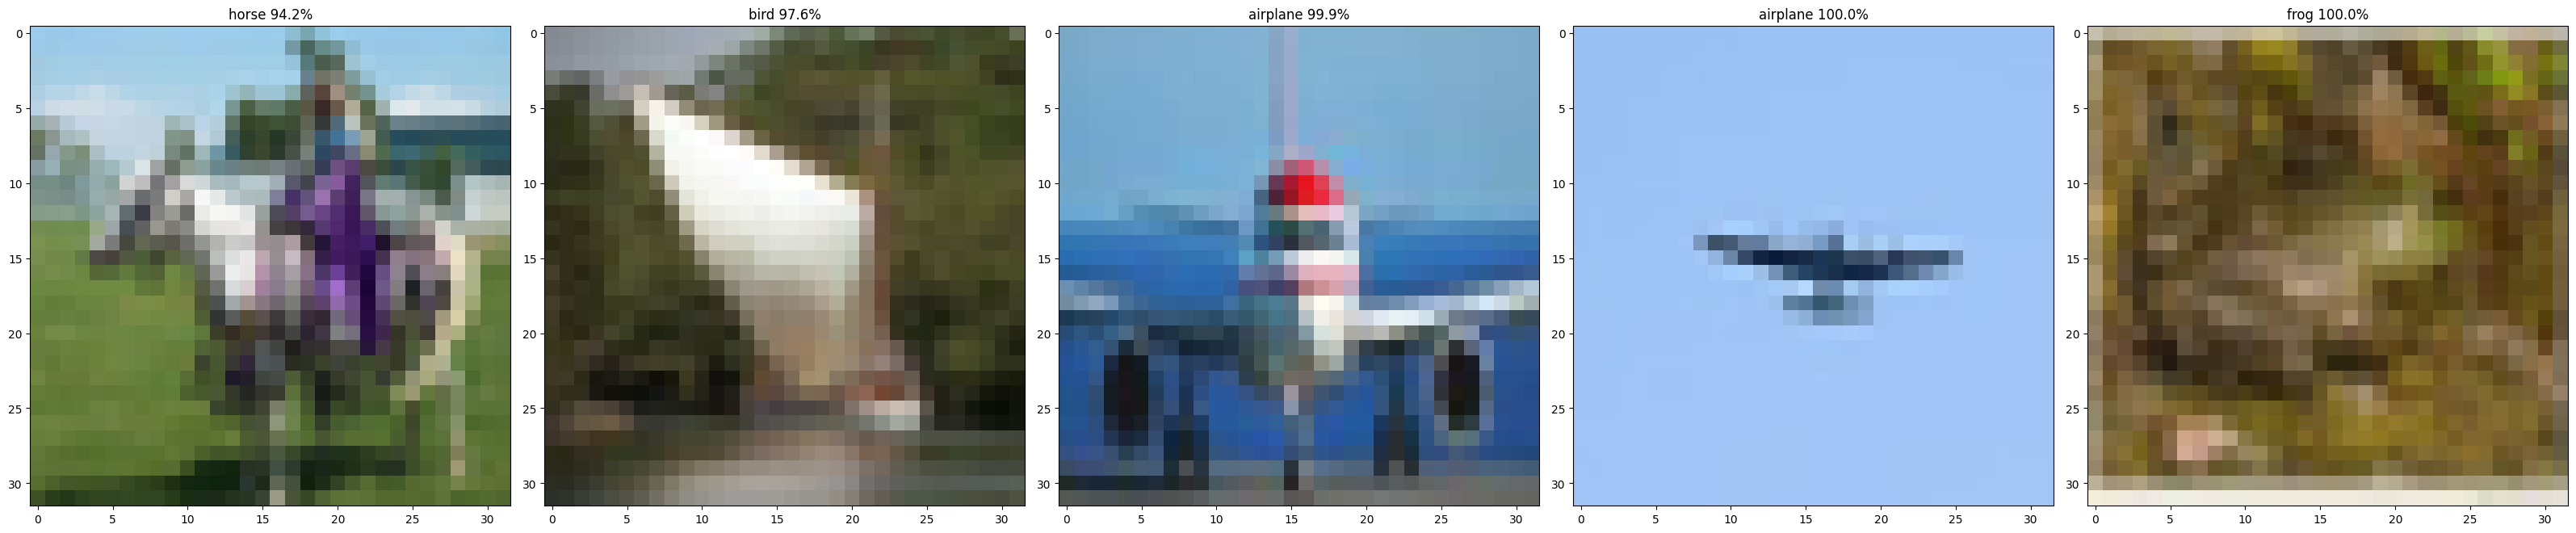

In [53]:
#Execution of the function to test the model
Test(TestLoader, Model, Loss, Device)

In [54]:
#The function FGMS is defined
def FGMS(Image, E, Grad):
    #Perturbation computation with the coefficient
    Perturbation = E*Grad.sign()
    #Add perturbations to the image
    PImage = Image + Perturbation
    #The max/min values are limited
    PImage = torch.clamp(PImage, 0, 1)
    Perturbation = torch.clamp(Perturbation, 0, 1)
    #Return the new picture and a picture of the perturbations
    return PImage , Perturbation

In [55]:
#Function to creation adversarial instances
def TestFGSM(dataloader, Model, Loss, Device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, Correct, NewCorrect, NewCorrect2 = 0, 0, 0, 0
    
    #For all the dataloader
    for X, y in dataloader:
        X = X.to(Device)
        y = y.to(Device)  
        #The gradient descent is required to compute FGSM
        X.requires_grad = True 

        #Model prediction
        Pred = Model(X)
        #Result verification
        Correct += (Pred.argmax(1) == y).type(torch.float).sum().item()

        #Compute gradient descent
        MyLoss = Loss(Pred, y)
        Model.zero_grad()
        MyLoss.backward()
        
        #Averserial instances with coef equal to 0.01
        NewImages, Perturbation = FGMS(X, 0.01, X.grad.data)
        NewPred = Model(NewImages)

        #Averserial instances with coef equal to 0.05
        NewImages2, Perturbation2 = FGMS(X, 0.05, X.grad.data)
        NewPred2 = Model(NewImages2)

        NewCorrect += (NewPred.argmax(1) == y).type(torch.float).sum().item()
        NewCorrect2 += (NewPred2.argmax(1) == y).type(torch.float).sum().item()

    Correct /= size
    NewCorrect /= size
    NewCorrect2 /= size

    #Accuracy for each dataset
    print(f"Test Error: \n Accuracy: {(100*Correct):>0.1f}%")
    print(f"Test Error: \n Accuracy: {(100*NewCorrect):>0.1f}%")
    print(f"Test Error: \n Accuracy: {(100*NewCorrect2):>0.1f}%")


    X.requires_grad = False 
    X = X.to("cpu")
    y = y.to("cpu")  

    #Convert result in probabilities
    m = torch.nn.Softmax(dim=1)
    ProbPred = m(Pred)
    ProbNewPred = m(NewPred)
    ProbNewPred2 = m(NewPred2)

    Pred = Pred.argmax(1).to("cpu") 
    NewImages = NewImages.to("cpu")
    NewPred = NewPred.argmax(1).to("cpu")
    NewImages2 = NewImages2.to("cpu")
    NewPred2 = NewPred2.argmax(1).to("cpu")

    #Take the highest value
    ProbPred = torch.max(ProbPred.to("cpu"), 1).values
    ProbNewPred = torch.max(ProbNewPred.to("cpu"), 1).values
    ProbNewPred2 = torch.max(ProbNewPred2.to("cpu"), 1).values

    #Display 5 images for each dataset
    Display5ImagesCIFAR10(X,Pred,ProbPred)
    Display5ImagesCIFAR10(NewImages,NewPred,ProbNewPred)
    Display5ImagesCIFAR10(NewImages2,NewPred2,ProbNewPred2)

Test Error: 
 Accuracy: 75.5%
Test Error: 
 Accuracy: 27.8%
Test Error: 
 Accuracy: 14.1%


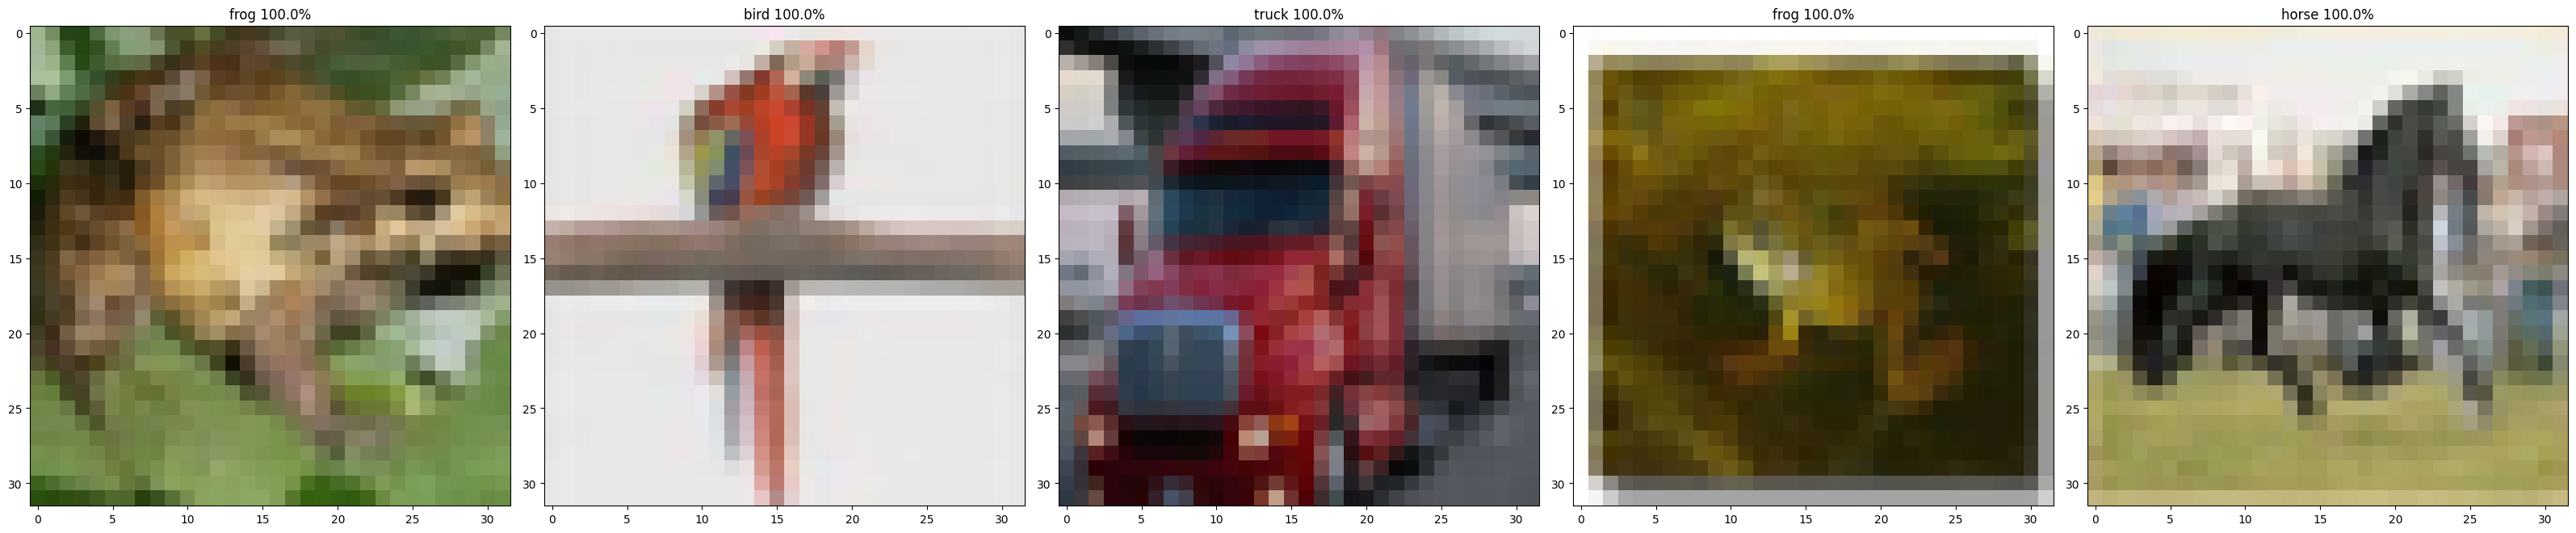

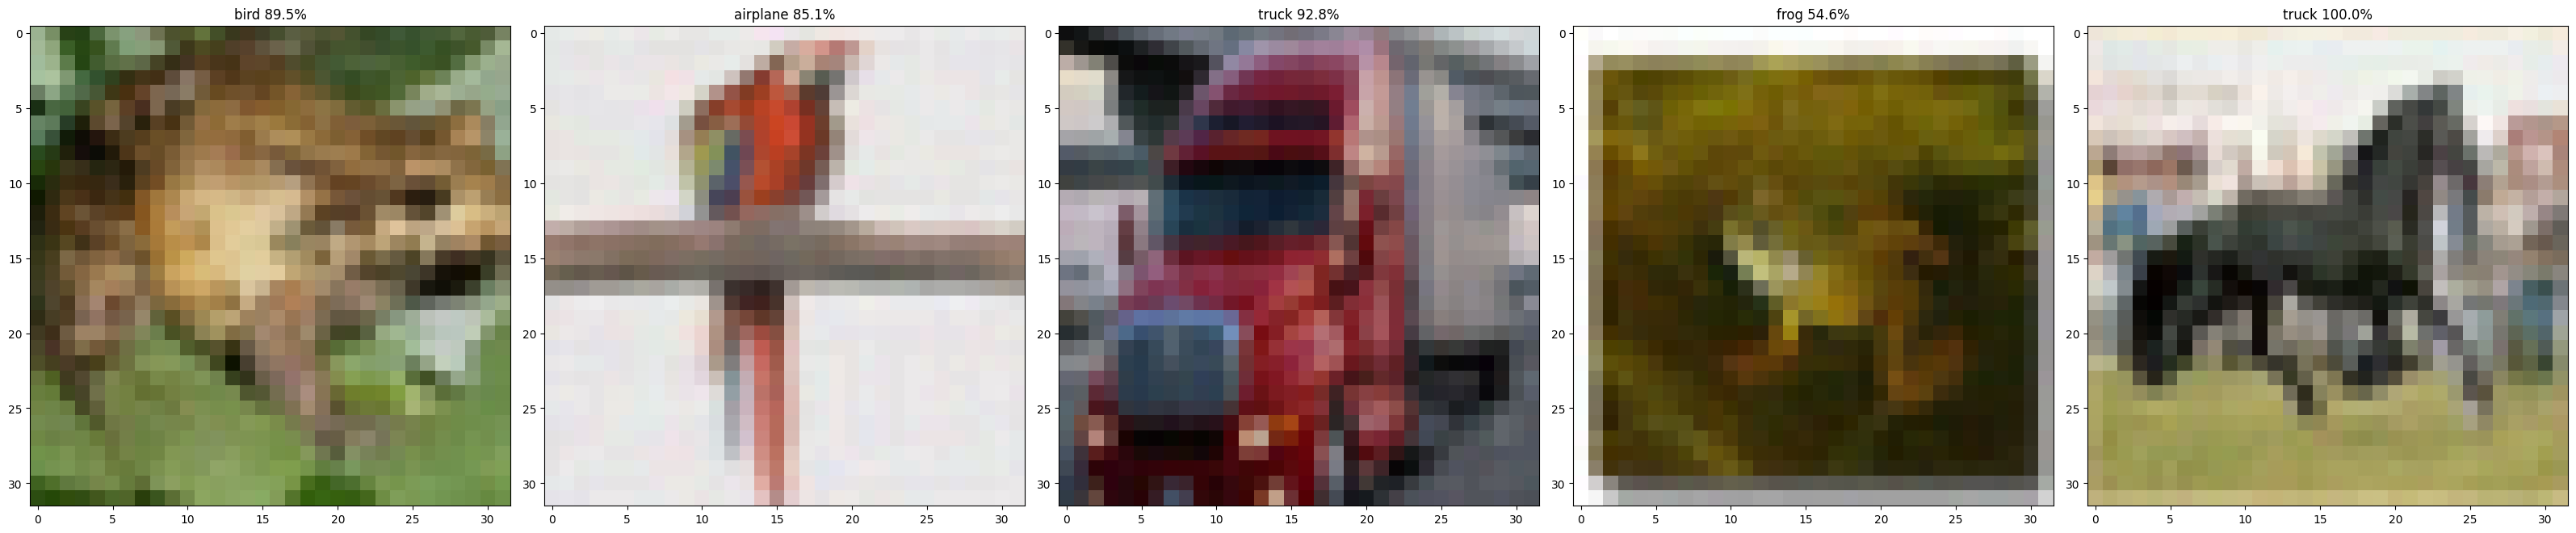

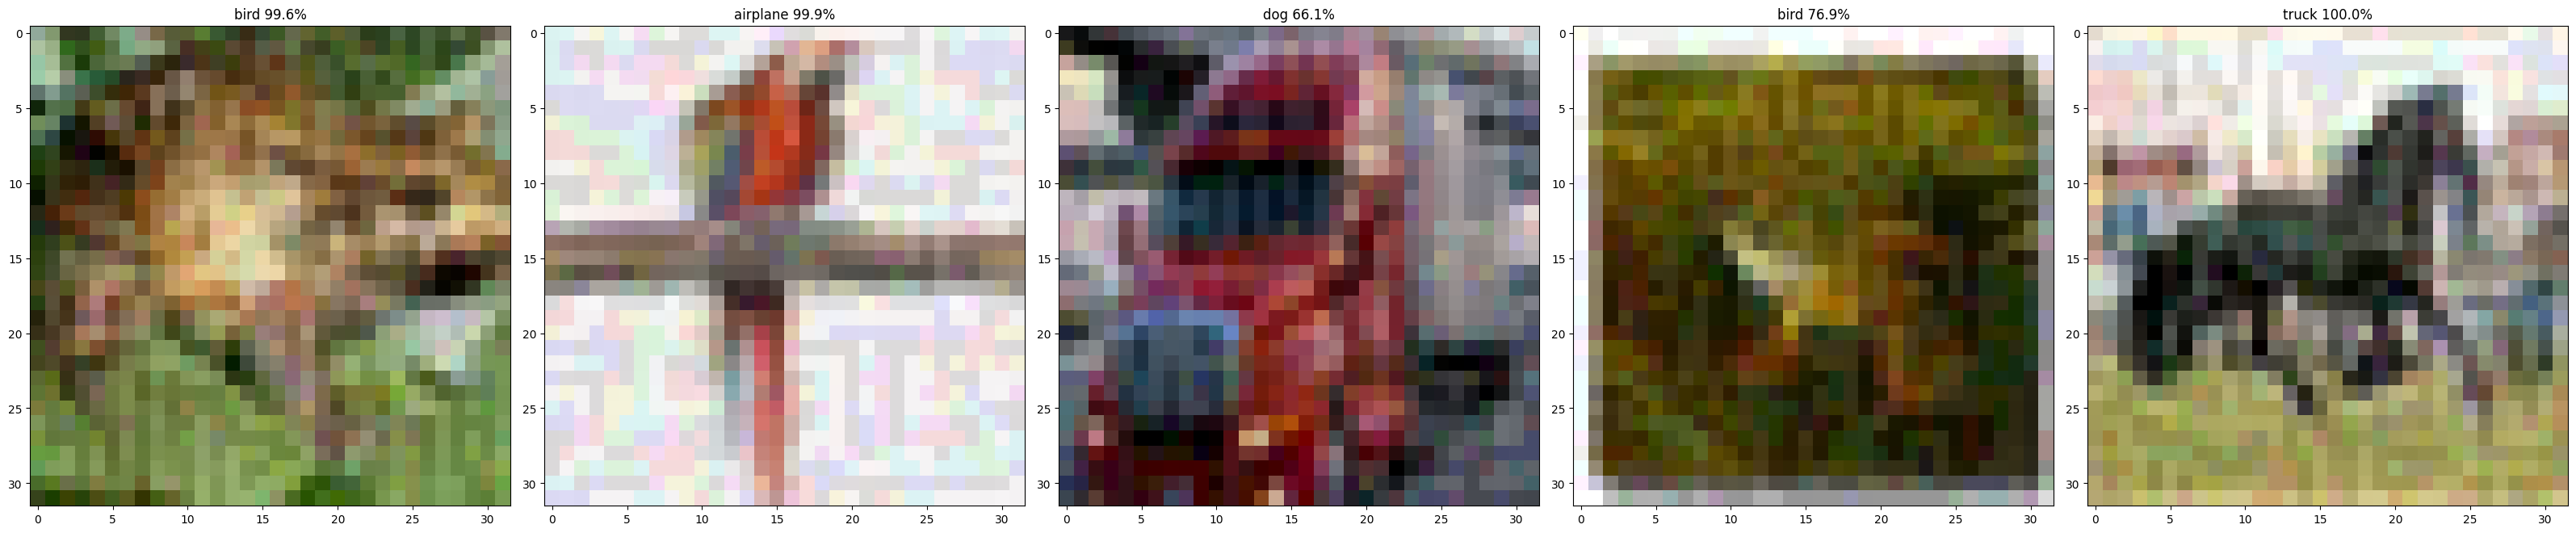

In [56]:
#Exuction of the function to create the adversarial instances
TestFGSM(TestLoader, Model, Loss, Device)